<a href="https://colab.research.google.com/github/bsorsch/transformer-dimensionality/blob/main/GPT_dimensionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer dimensionality

How does the dimensionality of representations evolve along the residual stream of a transformer?

In [ ]:
!pip install transformers
!pip install datasets

import torch
from tqdm.notebook import tqdm
import datasets
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style='ticks',font_scale=1.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
dataset = datasets.load_dataset("NeelNanda/pile-10k", split="train")
print(dataset)
print(dataset[0]['text'][:100])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.
Dataset({
    features: ['text', 'meta'],
    num_rows: 10000
})
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playi


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.pad_token_id = 0

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


In [ ]:
# for i in range(5):
#   print('======> Sample ' + str(i))
#   print(dataset['text'][i])

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=True,fp16=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT-2 size: 124.4M parameters


In [ ]:
model = model.cuda().eval()

In [ ]:
max_length = 128

batch_size = 16
hidden_states = []
logits = []
last_tokens = []
tokens = []
counter = 0
for i in tqdm(range(10)):
  batch = tokenizer(dataset[i*batch_size:(i+1)*batch_size]['text'],max_length=max_length, truncation=True,padding=True,return_tensors="pt")
  with torch.no_grad():
    tokens.append(batch['input_ids'])
    out = model(batch['input_ids'].cuda(),
                attention_mask=batch['attention_mask'].cuda())
    logits.append(out[0].cpu().numpy())
    hidden_states.append(torch.stack(out[2]).cpu().transpose(0,1))
    for am in batch['attention_mask']:
      if 0 in am:
        last_tokens.append(np.where(am==0)[0][0])
      else:
        last_tokens.append(max_length)
    del out
  counter += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
hidden_states = torch.vstack(hidden_states)
last_tokens = np.stack(last_tokens)
n_sentences,n_heads,n_context,N = hidden_states.shape
print(f'{n_sentences} sentences, {n_heads} heads, context size: {n_context}, {N} dimensions')

160 sentences, 13 heads, context size: 128, 768 dimensions


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
N = 768
singular_vals = []
for head_idx in range(n_heads):
  X = hidden_states[:,head_idx,-20:].reshape(-1,N)
  U,S,V = np.linalg.svd(X-X.mean(0))
  singular_vals.append(S)

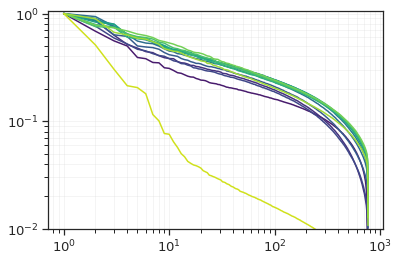

In [ ]:
# Plot spectra at each layer
with sns.color_palette('viridis',n_heads):
  for head_idx in range(n_heads):
    S = singular_vals[head_idx]
    plt.plot(range(1,N),S[1:]/S[1])
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both',alpha=0.2)
    # plt.title(f'Head: {head_idx}')
    plt.ylim([1e-2,1.05])

(0.01, 1.05)

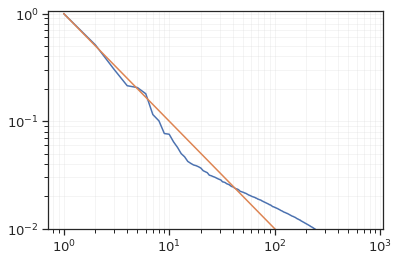

In [ ]:
plt.plot(range(1,N),S[1:]/S[1])
plt.plot(range(1,N),1/np.arange(1,N))
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both',alpha=0.2)
# plt.title(f'Head: {head_idx}')
plt.ylim([1e-2,1.05])

In [ ]:
Ds = []
for head_idx in range(n_heads):
    S = singular_vals[head_idx]
    D = (S**2).sum()**2/(S**4).sum()
    Ds.append(D)

Text(0, 0.5, 'Dimensionality')

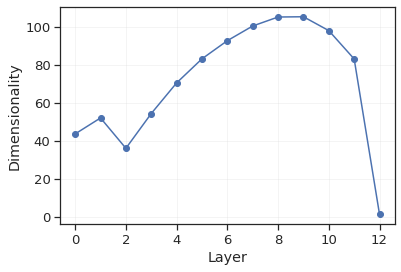

In [ ]:
plt.plot(Ds,'o-')
plt.grid(which='both',alpha=0.2)
plt.xlabel('Layer')
plt.ylabel('Dimensionality')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# How does this change along the context window?

N = 768
Ds_full = []
for i in tqdm(range(8)):
  for head_idx in range(n_heads):
    X = hidden_states[last_tokens==max_length,head_idx,i*n_context//8:(i+1)*n_context//8].reshape(-1,N)
    U,S,V = np.linalg.svd(X-X.mean(0))
    D = (S**2).sum()**2/(S**4).sum()
    Ds_full.append(D)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
Ds_full = np.stack(Ds_full).reshape(8,n_heads)

In [ ]:
from matplotlib import pyplot as plt

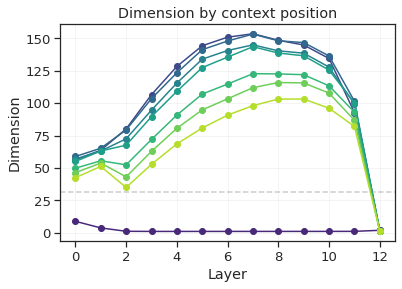

In [ ]:
with sns.color_palette('viridis',8):
  for i in range(8):
    plt.plot(Ds_full[i],'o-')
    plt.grid(which='both',alpha=0.2)
plt.xlabel('Layer')
plt.ylabel('Dimension')
plt.title('Dimension by context position')

eigs = 1/np.arange(1,N+1)
D_zipf = eigs.sum()**2/(eigs**2).sum()
plt.axhline(D_zipf, c='grey',linestyle='dashed',alpha=0.4)

## Dimension in final layer vs logit layer

In [ ]:
logits = torch.vstack(logits)

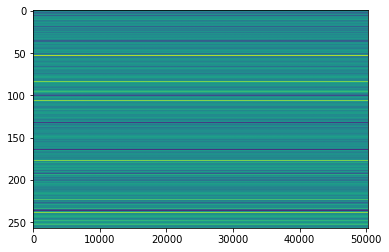

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(logits[:,-1],aspect='auto')

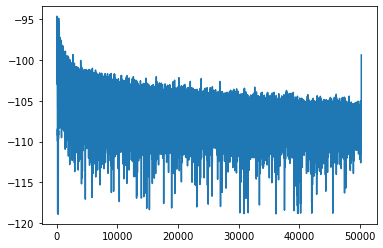

In [ ]:
plt.plot(logits[:,-1].mean(0))

# Why is the final layer so low-dimensional?

In [ ]:
head_idx = -1
X = hidden_states[last_tokens==max_length,head_idx,-20:].reshape(-1,N)
U,S,V = np.linalg.svd(X)

In [ ]:
C = np.cov(X.T)
eigs,eigvs = np.linalg.eigh(C)
eigvs = np.flip(eigvs,axis=-1).T
eigs = eigs[::-1]

(1e-07, 1.2)

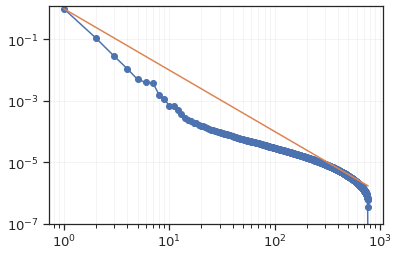

In [ ]:
# Plot spectrum
plt.plot(range(1,N+1),eigs/eigs[0],'o-')
plt.plot(range(1,N),1/np.arange(1,N)**2)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both',alpha=0.2)
# plt.title(f'Head: {head_idx}')
plt.ylim([1e-7,1.2])

In [ ]:
W0 = model.lm_head.weight.detach()

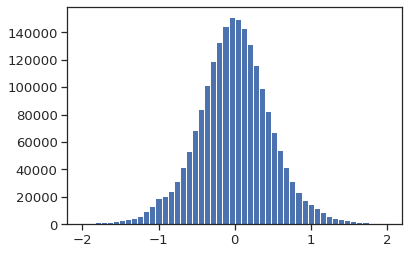

In [ ]:
plt.hist(X.ravel(),bins=50,range=(-2,2));

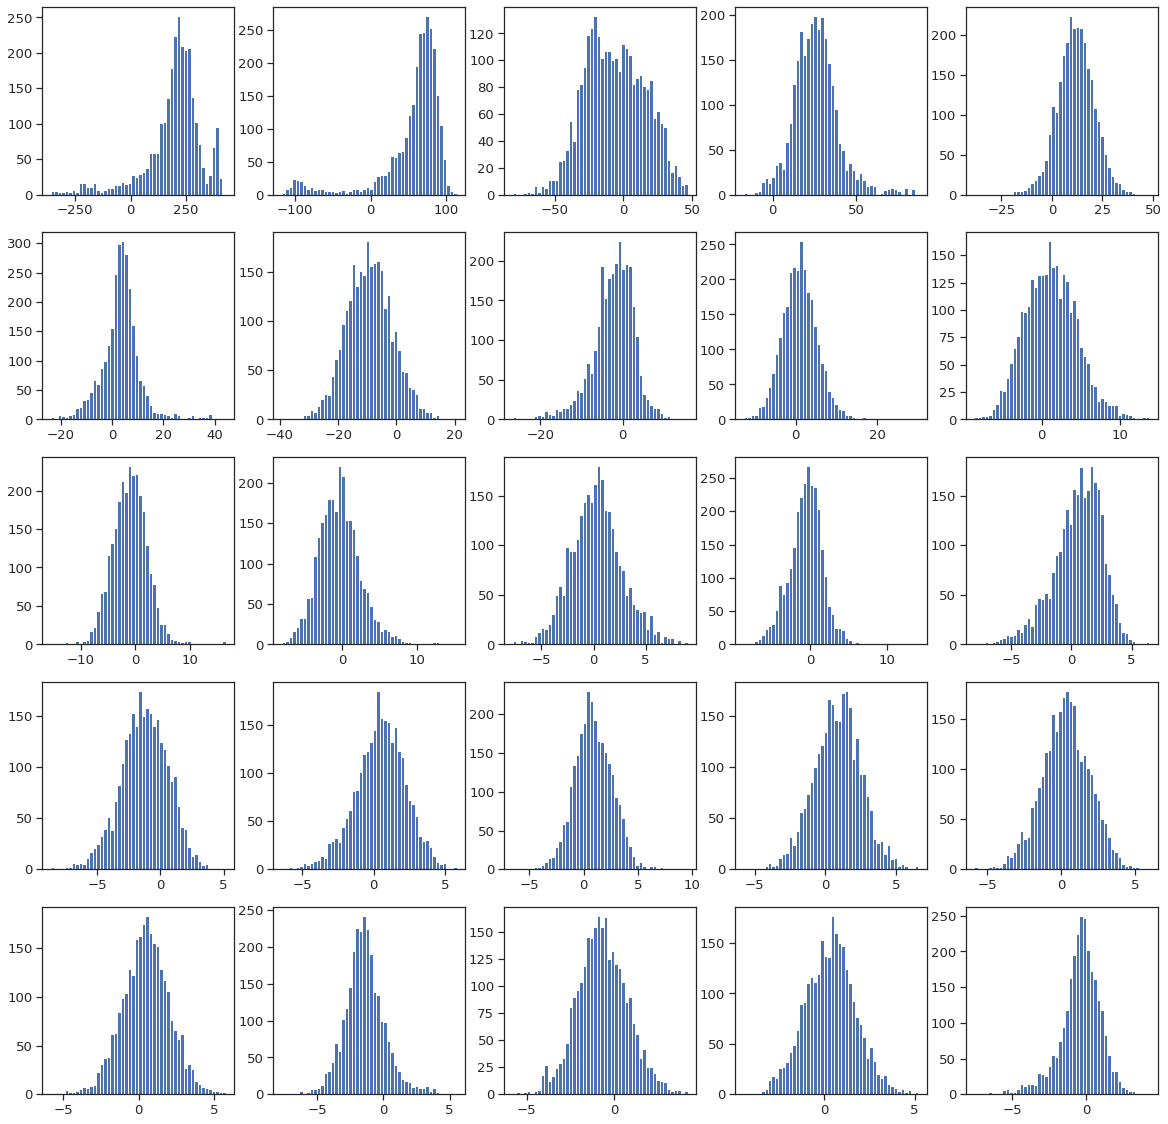

In [ ]:
# Look at the projections along the readout directions
plt.figure(figsize=(20,20))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.hist(X@eigvs[i],bins=50);

In [ ]:
A = eigvs[:20].copy()
top_subspace_overlaps = (torch.tensor(A,dtype=torch.float32).cuda()@W0.T).cpu()

In [ ]:
mid_subspace_overlaps = (torch.tensor(V[300:320]).cuda()@W0.T).cpu()

In [ ]:
tokenizer.decode(np.where(top_subspace_overlaps[0][:1000]>0.56)[0])

'������������������\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f\x7f'

In [ ]:
tokenizer.decode(np.where(top_subspace_overlaps[1][:1000]>0.46)[0])

'������������������\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f\x7f'

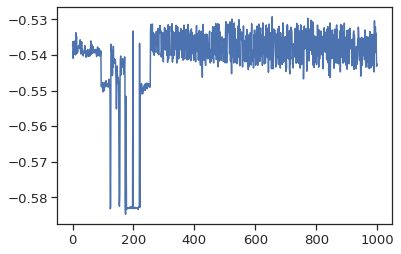

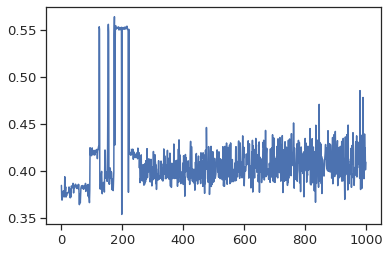

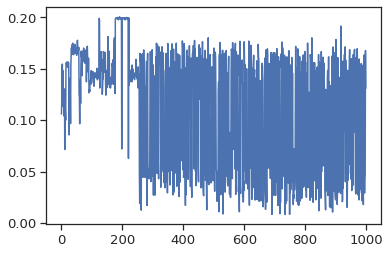

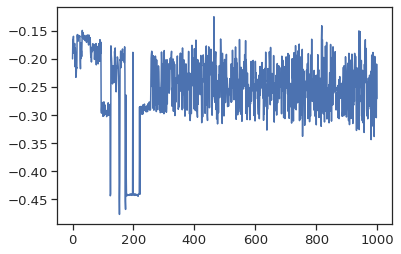

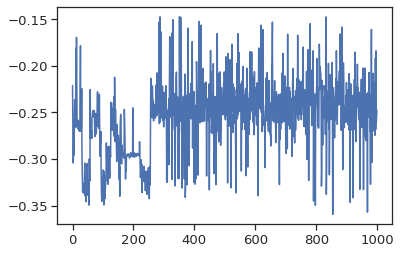

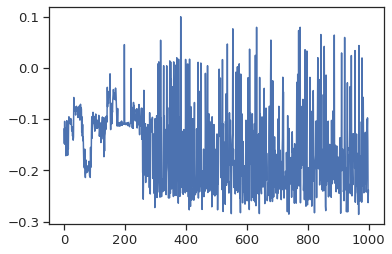

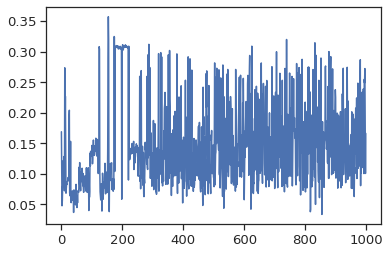

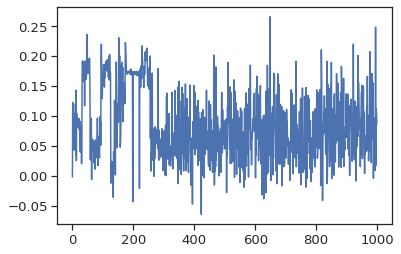

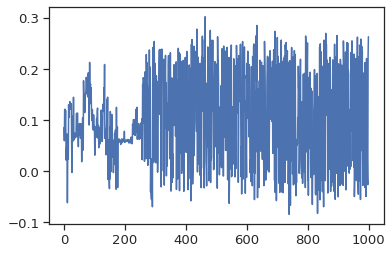

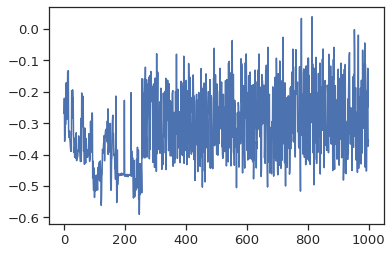

In [ ]:
for i in range(10):
  plt.figure()
  plt.plot(top_subspace_overlaps[i][:1000])

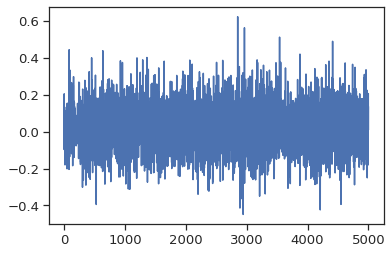

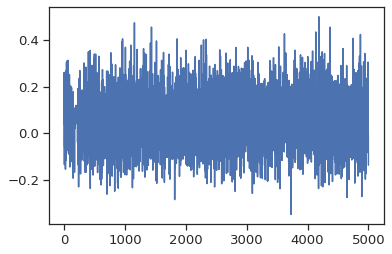

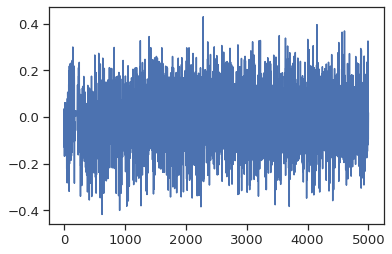

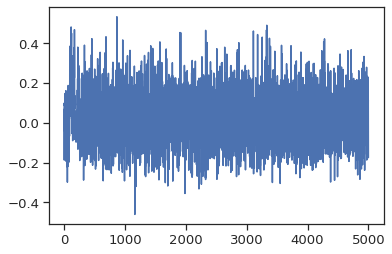

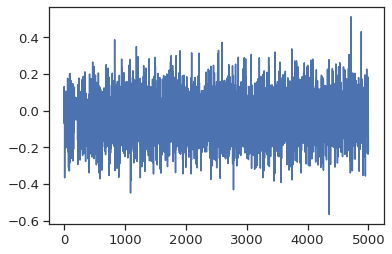

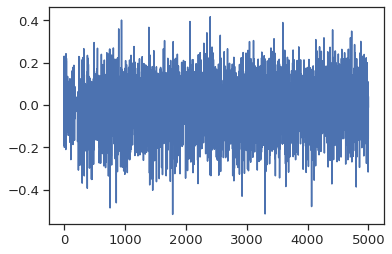

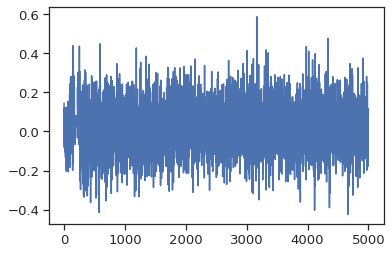

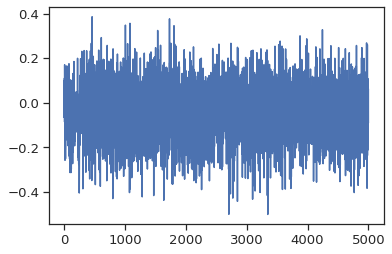

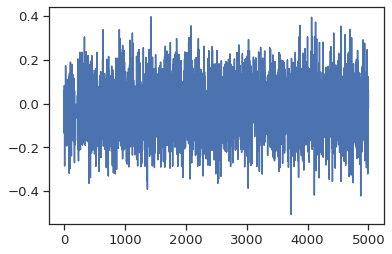

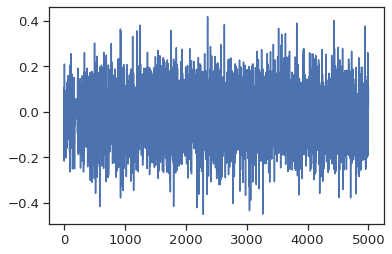

In [ ]:
for i in range(10):
  plt.figure()
  plt.plot(mid_subspace_overlaps[i][:5000])

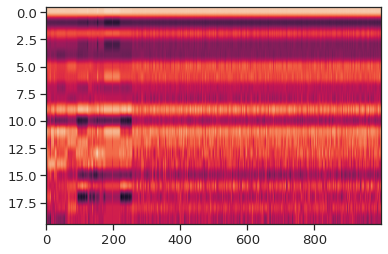

In [ ]:
plt.imshow((top_subspace_overlaps[:,:1000]),aspect='auto')

In [ ]:
logits[0].shape

(16, 128, 50257)

In [ ]:
b = 6
preds = logits[b][0].argmax(-1)
for i in range(20):
  print(tokenizer.decode(tokens[b][0][:i+1]) + '[' + tokenizer.decode(preds[i]) + ']')

Sen[.]
Sen.[ John]
Sen. Bernie[ Sanders]
Sen. Bernie Sanders[ (]
Sen. Bernie Sanders ([I]
Sen. Bernie Sanders (I[-]
Sen. Bernie Sanders (I-[V]
Sen. Bernie Sanders (I-VT[)]
Sen. Bernie Sanders (I-VT)[ said]
Sen. Bernie Sanders (I-VT) regained[ the]
Sen. Bernie Sanders (I-VT) regained his[ lead]
Sen. Bernie Sanders (I-VT) regained his previously[ held]
Sen. Bernie Sanders (I-VT) regained his previously held[ Senate]
Sen. Bernie Sanders (I-VT) regained his previously held second[-]
Sen. Bernie Sanders (I-VT) regained his previously held second place[ in]
Sen. Bernie Sanders (I-VT) regained his previously held second place position[ in]
Sen. Bernie Sanders (I-VT) regained his previously held second place position,[ but]
Sen. Bernie Sanders (I-VT) regained his previously held second place position, according[ to]
Sen. Bernie Sanders (I-VT) regained his previously held second place position, according to[ the]
Sen. Bernie Sanders (I-VT) regained his previously held second place position, acc

In [ ]:
bad_tokens = np.array([124, 125, 153, 154, 155, 173, 174, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221])

In [ ]:
tokenizer.decode(preds)

'. What\nI only- the with\n a\n.\nThe\'m to make the tableview with a array of structure structure array\n following thing of the structure is the name of The is the I want to\n\n table = =StringrictedantMenu = {Menuaurant. {\n\n func menu(Load() { menu\n~~\xa0 }.viewDidLoad()\n\n menu = menu.menu: "Shake", price: [)\n\n   super shake = [(name: "Fries", carbs: 20)\n\n  let let fries = Item(name: "Beverages",'

'Q:\n\nNot populating tableview with structure array\n\nI need to populate my tableView with an array of a structure. The first property of the structure is the name. This is what I tried...\nvar menuArray:[Restaurant] = [Restaurant]()\n override func viewDidLoad() {\n    super.viewDidLoad()\nlet shake = Item(name: "Shake", carbs: 20)\n    let fries = Item(name: "Fries", carbs: 30)\n\n    let beverages = Category(name: "Beverages'

In [ ]:
W0 = model.lm_head.weight

In [ ]:
logits2 = (hidden_states[0,-1].cuda()@W0.T).cpu()

In [ ]:
logits2.shape

torch.Size([128, 50257])

In [ ]:
tokenizer.decode(logits2.argmax(-1))

" is not by and it to\n can also it�@iv of the Femptes Survivors� on your. iOS you iOS iPhone.\n on Android web is just too you can to be the-player gestures it-. for's be a pain tricky.\n\n� are�t a lot of want�ve like to say about. I think�d talk into the single in anda in the a game game I wrong,wrong,,\n\nIclusionss\nThe on the past of a the of the hardest things I had to do. I\nI, I wanted a idea for how I of game I"

In [ ]:
out = model.generate(do_sample=True,max_length=100,temperature=0.9)
tokenizer.decode(out.squeeze())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'<|endoftext|>A group of students at Yale University has organized a protest group called "Black Student Privilege" to oppose the efforts of one of the world\'s leading liberal professors for President Trump.\n\n"One of the worst things that ever happened to Black students has happened to us," the group, which has been organizing protests throughout the Middle East and North Africa, told USA Today. "As a result, we have been forced to cancel classes with students of color. We will not go to class with'

'<|endoftext|>\nThe first time I saw the new version of the game, I was so excited. I'